In [1]:
import numpy as np
from keras.layers import Dense, Input, Lambda, Flatten
from keras.models import Model
import keras
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.


In [123]:

MAXEPS = 200           # Set max number of episodes
TSTEPS = 500           # Set max number of iterations because there are undefined states
EPSILON = 0.8	
TLIM = 2
ACTIONS = [-TLIM, 0, TLIM]
ANGLE_MAX_INIT = 0.4           # For state initialization
EPSILONMIN = 0.3

ANGLERANGE = 0.7
RATERANGE = 0.3

GAMMA = 0.999

TIMEDELTA = 0.05              # Timestep of integration. Each substep lasts this long.



In [124]:

class NeuralNetwork:
	def __init__(self, input_size, output_size):
		self.input_size = input_size
		self.output_size = output_size

		#optimizer = Adam(0.0002, 0.2)

		NNinput = Input(shape = (self.input_size,), name = 'NNinput')
		x = Dense(64, activation = 'relu')(NNinput)
		x = Dense(32, activation = 'relu')(x)
		NNoutput = Dense(self.output_size, activation = 'linear')(x)
		self.model = Model(inputs = NNinput, outputs = NNoutput)
		self.model.compile(loss = 'mean_squared_error', optimizer = 'adam')

class Environment:
	def __init__(self):
		# state_init = [ 2*ANGLE_MAX_INIT * np.randn() - ANGLE_MAX_INIT, 0. ]
		self.state = np.zeros([1,2]) #state_init
		self.episode = 0
		self.historyReward = []
		self.cumHistoryReward = []

	def initialize(self):
		self.state = np.array([ [ 2*ANGLE_MAX_INIT * np.random.randn() - ANGLE_MAX_INIT, 0. ]] )
		self.historyReward = []

	def updateEnv(self, action):
		next_state = numericalIntegration(PendulumDynamics, self.state, action)
        
		if ( (next_state[0][0] > np.pi - ANGLERANGE) and 
        		(next_state[0][0] < np.pi + ANGLERANGE)   and
        			 ( np.absolute(next_state[0][1]) < RATERANGE ) ):
			bonus = 20
			success = True

            # if length(bestSwingUp) > iter:
            #     bestSwingUp = takenA(1:iter)
            #     bestPosInit = posInit
		else:
			bonus = 0
			success = False

		reward = Rfunc(next_state[0][0], next_state[0][1]) + bonus

		return next_state, reward, success

	def rewardHistory(self, reward):
		self.historyReward.append(reward)

	def checkIfCrashed(self, process):
		isCrashed = False
		if process == 'SwingUp':
			if np.absolute(self.state[0][1])  > 8 :
				isCrashed = True
			if (self.state[0][0] > 3*np.pi/2) or (self.state[0][0] < np.pi/2):
				isCrashed = True
		return isCrashed

	def nextEpisode(self):
		self.episode += 1
		self.cumHistoryReward.append(self.historyReward)

def PendulumDynamics(state, torque):
	g = 9.8
	L = 1
	m = 1
	b = 0.01
	# state = state
	zdot = np.array([state[0][1], - g/L * np.sin(state[0][0]) + torque/m/L/L - b*state[0][1]/m/L/L])
	return zdot

def numericalIntegration(function_, state_init, input_, dt = TIMEDELTA):
    state = state_init
    for i in range(2):
        k1 = function_(state,input_)
        k2 = function_(state + dt / 2 *k1 ,input_)
        k3 = function_(state + dt / 2 *k2 ,input_)
        k4 = function_(state + dt * k3 ,input_)
      
        state = state + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)
    # print(state)
    if (state[0][0] < 0) or (state[0][0] > 2*np.pi):
        state[0][0] = wrapAngle(state[0][0])

    return state

class Agent:
	def __init__(self, state_init, eps):
		self.actions = np.array(ACTIONS)
		#print(np.shape(state_init,))
		self.state = state_init
		self.Qfuntion = NeuralNetwork(np.size(self.state), np.size(self.actions)) 
		self.episode = 0
		
		self.actions = []
		self.states = []
		self.Qvalues = []

        
		self.cumCostHistory = []
		self.memory = []
		
		self.NNhistory = []
		self.CostHistory = []

		self.best_action = []
        
		self.eps = eps

	def initialize(self, state_init):
		self.state = state_init
		self.actions = []
		self.Qvalues = []
		self.states = []
		self.CostHistory = []

	def updatePolicy(self, states, Qexpected, epochs = 2, batch_size = 100):
		history = self.Qfuntion.model.fit(states, Qexpected, epochs = epochs, batch_size = batch_size, verbose = 0)
		self.NNhistory.append(history)
		J = costFunction(Qexpected, np.squeeze(self.Qvalues))	
		self.CostHistory.append(J)

	def chooseAction(self, inputs):
		Qhat = self.Qfuntion.model.predict(inputs)
		if np.random.rand(1) > self.eps: 
			# Qhat = np.max(Q)
			Qhat_index = np.argmax(Qhat)
		else:
			Qhat_index = np.random.randint(len(ACTIONS))
			# Qhat = 
		return Qhat_index, np.max(Qhat), Qhat

	def updateMemory(self, state, action, q_v):
		self.states.append(state)
		self.actions.append(action)
		self.Qvalues.append(q_v)

	def nextEpisode(self):
		self.episode += 1
		self.memory.append( np.concatenate( [np.expand_dims(np.array(self.actions), axis = 1), np.squeeze(np.array(self.states)), np.squeeze(np.array(self.Qvalues))] , axis = 1) ) 

def costFunction(output, yhat):
	J = 0.5 * np.matmul( np.transpose((output - yhat)), (output - yhat))
	return np.linalg.norm(J)

def Rfunc(q, qdot):
	g = 9.8
	L = 1
	m = 1
	Ed = 2*m*g*L 
	Ek = 2*m*L**2 * qdot**2
	Ep = m*g*L*(1-np.cos(q))
	return - np.absolute(Ed - Ek - Ep)   #-(np.absolute(np.pi-np.absolute(q))**1 + 0.2*(np.absolute(qdot)**2))

def wrapAngle(angle):
	normalAngle = np.absolute(2*np.pi - np.absolute(angle))  # Normalization function 
	return normalAngle

In [122]:
Rfunc(np.pi-0.5, 0.0)
EPSILON

0.8

In [129]:
import time
# -------- Q-learning -------- #
epsilonDecay = 0.99   # Decay after each episode
success = False

eps = EPSILON

env = Environment()	
agent = Agent(env.state, eps)


time_lst = []
time_lst.append(time.time())

with tqdm(total=MAXEPS, desc="Total episode", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    
	for episode in range(MAXEPS):
		pbar.update(1)
		env.initialize()
		agent.initialize(env.state)
	
		for step in range(TSTEPS):
			# Choose action from state suing policy
			action_i, _, _ = agent.chooseAction(agent.state)
			# Take action and see reward and next_state
			next_state, reward, success = env.updateEnv(action_i)
			# Observe Q for next_state
			_, qhat_max, qhat = agent.chooseAction(next_state)
			# Save reward history
			env.rewardHistory(reward)
			# Save
			qhat[0][action_i] = reward + GAMMA * qhat_max if success == False else reward
			agent.updateMemory(next_state, ACTIONS[action_i] , qhat)
			# state = next_state
			agent.state = next_state
			env.state = next_state
            
			# Check crashing
			if env.checkIfCrashed('SwingUp'):
				pass#break

		# Epsilon update
		agent.eps = (agent.eps * epsilonDecay) if (agent.eps >= EPSILONMIN) else agent.eps
		agent.updatePolicy( np.squeeze(agent.states), np.squeeze(agent.Qvalues) )
		env.nextEpisode()
		agent.nextEpisode()
	#agent.prepareData()
	sts = agent.states
	act = agent.actions
	best = agent.best_action
	#showResults(sts,act,best)


Total episode: 100%|██████████ [ time left: 00:00 ]


In [88]:
agent.CostHistory

[0.0]

In [130]:
agent.eps

0.2987714243634155

In [5]:
import matplotlib.pyplot as plt

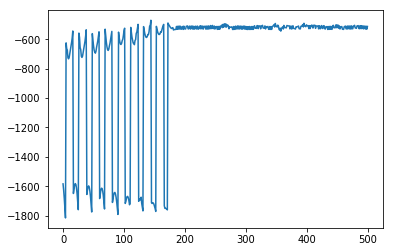

In [140]:
plt.plot(np.array(agent.memory)[-2,:,5])

In [100]:
np.array(env.cumHistoryReward).shape

(200, 500)

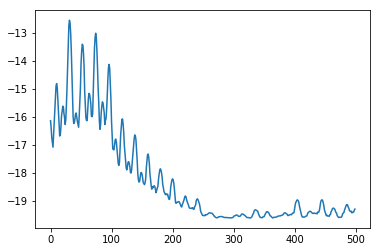

In [107]:
plt.plot(np.array(env.cumHistoryReward)[-10,:])

In [75]:
agent.Qfuntion.model.predict(np.array([[0.2,0]]))

array([[-624.5384 , -624.76447, -626.1947 ]], dtype=float32)

In [76]:
xd_sp = np.linspace(-4,4,50)
x_sp = np.linspace(np.pi/2,3*np.pi/2,50)
x_grid, xd_grid = np.meshgrid(x_sp,xd_sp)

xdnT_grid = np.zeros(np.shape(x_grid))
xd0T_grid = np.zeros(np.shape(x_grid))
xdpT_grid = np.zeros(np.shape(x_grid))
xddnT_grid = np.zeros(np.shape(x_grid))
xdd0T_grid = np.zeros(np.shape(x_grid))
xddpT_grid = np.zeros(np.shape(x_grid))
for i in range(np.shape(x_grid)[0]):
    for j in range(np.shape(x_grid)[1]):
        state_temp = np.array([x_grid[i,j] , xd_grid[i,j]])[None,:]
        q_temp = agent.Qfuntion.model.predict(state_temp)
        ActIndex_temp = np.argmax(q_temp);
        stated_temp = PendulumDynamics(state_temp, ACTIONS[ActIndex_temp])
        xddnT_grid[i,j] = stated_temp[1]*(ActIndex_temp==0);
        xdd0T_grid[i,j] = stated_temp[1]*(ActIndex_temp==1);
        xddpT_grid[i,j] = stated_temp[1]*(ActIndex_temp==1);
        xdnT_grid[i,j] = xd_grid[i,j]*(ActIndex_temp==0);
        xd0T_grid[i,j] = xd_grid[i,j]*(ActIndex_temp==1);
        xdpT_grid[i,j] = xd_grid[i,j]*(ActIndex_temp==2);


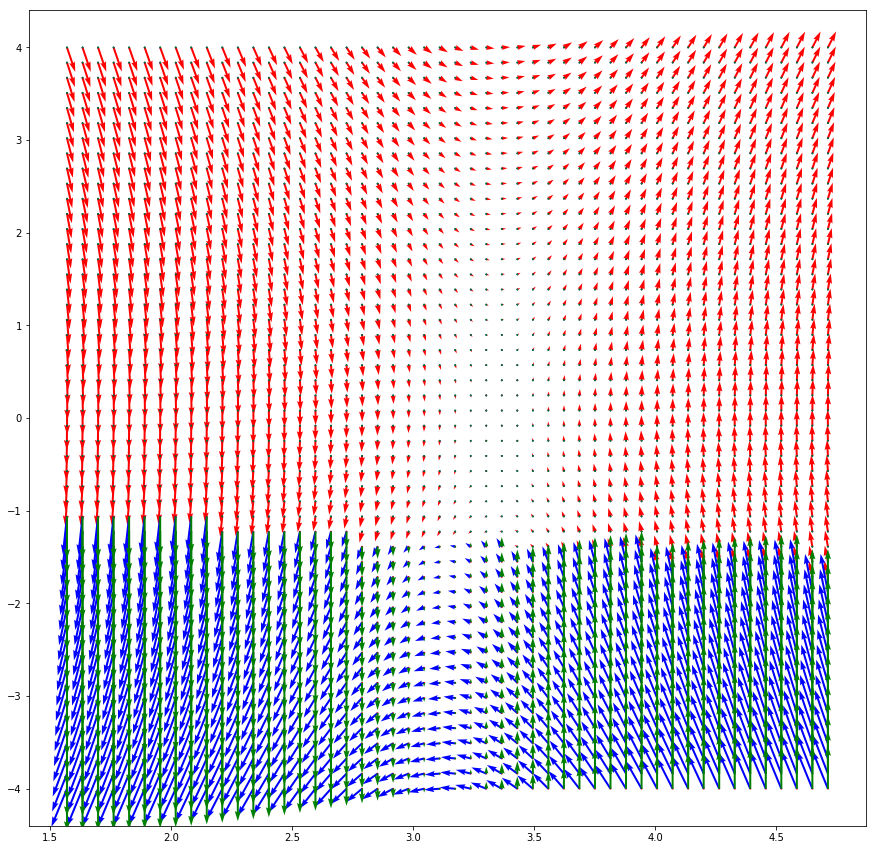

In [108]:
SCALE = 10
f, ax = plt.subplots(figsize=(15,15))
ax.quiver(x_grid,xd_grid,xdnT_grid/SCALE,xddnT_grid/SCALE, color = 'red')

ax.quiver(x_grid,xd_grid,xd0T_grid/SCALE,xdd0T_grid/SCALE, color = 'blue')
ax.quiver(x_grid,xd_grid,xdpT_grid/SCALE,xddpT_grid/SCALE, color = 'green')
plt.show()